## Bayesian Optimisation Verification

In [26]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error
from itertools import product
from gp_para import gp_tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Seed for reproducibility
rng = np.random.default_rng(12345)

### Impot data for training and evaluation
# import data sheet (time:0~5000s) with temp 120, 140, 160, 180
address = 'data/degradation.xlsx'
y_normal = np.empty(shape=[0,1])
i = 3
list_temp = (120,140,160,180)
for temp in list_temp:
    df = pd.read_excel(address,sheet_name = 'normal data',usecols = [i],names = None,nrows = 5000)
    df = df.values.tolist()
    df = np.array(df)
    y_normal =  np.append(y_normal,df)
    i+=1

In [42]:
### Data setup and indexing
# Data parameters
NUM_OF_DATA_POINTS = 20
NUM_OF_PLOT_POINTS = 100
NUM_OF_EXTRA_DATA = 20
# Kernel setting and prediction
LOWEST_NOISE_LEVEL = 1e-16
HIGHEST_NOISE_LEVEL = 1e-12
KERNEL_ALPHA = 1e-15
# max mse before remove it from final performance plot
MAX_mse_allowed = 1e-5


def data_setup(NUM_OF_DATA_POINTS,y_normal):
    ################################################################################
    # Data setup with half points evenly spread in 0-999, another half in 1000-4999
    X_num = np.hstack([np.linspace(0,999,num=int(3*NUM_OF_DATA_POINTS/4),dtype=int),np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS/4),dtype=int)])

    # Data setup with1/4 in 0-199, 2/4 in 200-999, 1/4 1000-4999
    # X_num = np.hstack([ np.linspace(0,199,num=int(NUM_OF_DATA_POINTS/4),dtype=int),
    #                     np.linspace(200,999,num=int(NUM_OF_DATA_POINTS/2),dtype=int),
    #                     np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS/4),dtype=int)])

    # Data setup with 2/5 in 0-99, 2/5 in 100-999, 1/5 1000-4999
    # X_num = np.hstack([ np.linspace(0,99,num=int(NUM_OF_DATA_POINTS*2/5),dtype=int),
    #                     np.linspace(199,999,num=int(NUM_OF_DATA_POINTS*2/5),dtype=int),
    #                     np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS*1/5),dtype=int)])

    # Data setup with  points evenly spread 
    # X_num = np.linspace(0,4999,num=int(NUM_OF_DATA_POINTS),dtype=int)

    # Data setup with points spread in log space
    # X_num = np.logspace(0,np.log10(4999), num=NUM_OF_DATA_POINTS, base=10.0, dtype=int)
    # HIGHEST_NOISE_LEVEL = 1e-15
    # KERNEL_ALPHA = 8e-5

    ################################################################################

    X_ = np.arange(0,5000).astype(int)
    x_normal = np.empty(shape=[0,2])
    temp_list = np.array([120,140,160,180])

    for temp in temp_list:
        df_temp = np.full((5000,1),temp)
        x_normal_partial = np.hstack([X_.reshape(5000,1),df_temp])
        x_normal =  np.concatenate([x_normal,x_normal_partial])

    Y = y_normal[np.hstack([X_num,X_num+5000,X_num+5000*2,X_num+5000*3])]
    X = np.empty(shape=[0,2])
    for temp in temp_list:
        df_temp = np.full((int(NUM_OF_DATA_POINTS),1),temp)
        X_partial = np.hstack([X_num.reshape(int(NUM_OF_DATA_POINTS),1),df_temp])
        X = np.concatenate([X, X_partial])
    return X,Y,X_num,x_normal

In [36]:
# Plot function to show confidence bounds 
def plot(gp,X,temp_list,NUM_OF_PLOT_POINTS,NUM_OF_DATA_POINTS):
    x1 = np.linspace(X[:,0].min(), X[:,0].max(),num = NUM_OF_PLOT_POINTS)
    x2 = np.linspace(X[:,1].min(), X[:,1].max(),num = NUM_OF_PLOT_POINTS)
    x1x2 = np.array(list(product(x1, x2)))
    y_pred, MSE = gp.predict(x1x2, return_std=True)
    X0p, X1p = x1x2[:,0].reshape(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS), x1x2[:,1].reshape(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS)
    Zp = np.reshape(y_pred,(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS))

    fig = plt.figure(figsize=(16,24),facecolor='white')
    ax = fig.add_subplot(3,2,1, projection='3d')
    surf = ax.plot_surface(X0p, X1p, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
    ax.scatter(X[:,0],X[:,1],Y)
    fig.colorbar(surf, aspect=5)

    ax = fig.add_subplot(3,2,2)
    pcm = ax.pcolormesh(X0p, X1p, Zp)
    fig.colorbar(pcm, ax=ax)

    i = 1
    j = NUM_OF_DATA_POINTS
    k = 0
    plot_index = 3
    for temp in temp_list:
        plt.subplot(3,2,plot_index),plt.plot(x1,Zp[:,i],label = str(temp)+' prediction',c='red',lw=2,zorder=3)
        plt.scatter (X_num,Y[j-NUM_OF_DATA_POINTS:j],label = str(temp)+'training',c='blue',zorder=2)
        plt.legend()
        plt.title('Plot for '+str(temp))
        plt.scatter(X_,y_normal[k:k+5000],label = str(temp)+' true',s=1,c='grey',zorder=1),
        # plt.yticks(np.arange(0.6,0.8,0.01)),plt.title(str(temp)),plt.legend(),plt.tight_layout
        i += int(NUM_OF_PLOT_POINTS/3-1)
        j += NUM_OF_DATA_POINTS
        k+=5000
        plot_index+=1
    plt.savefig('plot_comp.png')
    plt.show()


GaussianProcessRegressor(alpha=1e-06,
                         kernel=1**2 * RBF(length_scale=6.17) + WhiteKernel(noise_level=1e-16))


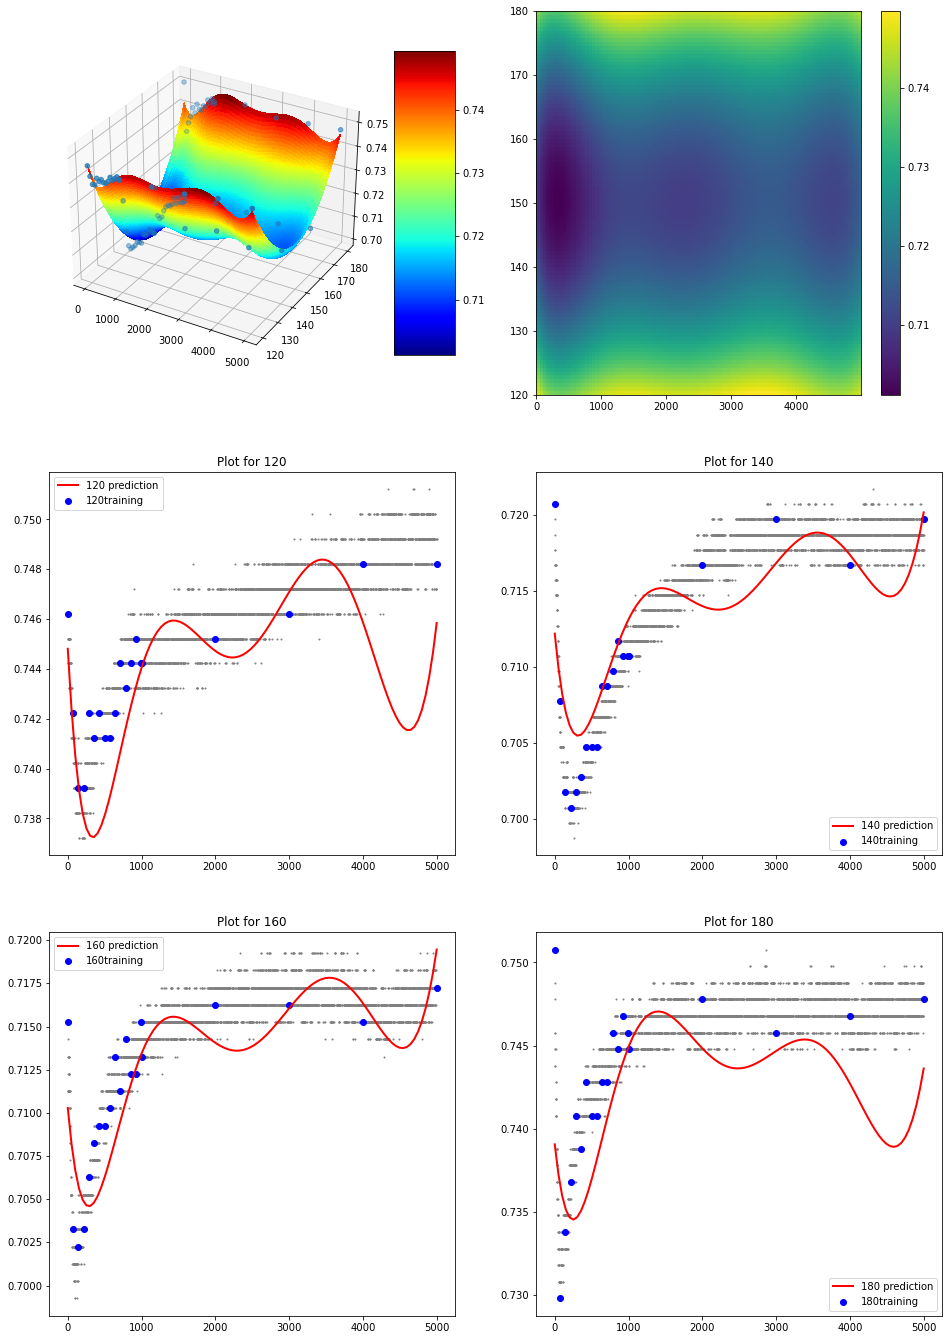

In [43]:
gp = GaussianProcessRegressor(alpha=1e-06 ,kernel = 1**2 * RBF(length_scale=6.17) + WhiteKernel(noise_level=1e-16))
#2.35,0.27,4.24,6.17,17,0.32

NUM_OF_DATA_POINTS = 20
X,Y,X_num,x_normal = data_setup(NUM_OF_DATA_POINTS,y_normal)

gp.fit(X,Y)
print(gp)
plot(gp,X,temp_list,NUM_OF_PLOT_POINTS,NUM_OF_DATA_POINTS)

Excessive mse at 8.0 points = 1.4498599184561554
Excessive mse at 12.0 points = 0.015264137778356064
Excessive mse at 16.0 points = 0.0029698568277170823

Mean squared error


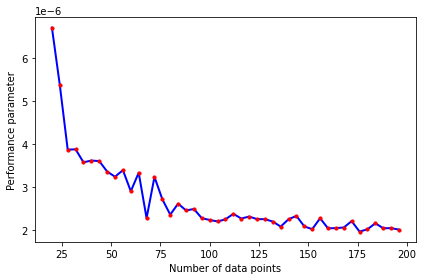

Log marginal likelihood


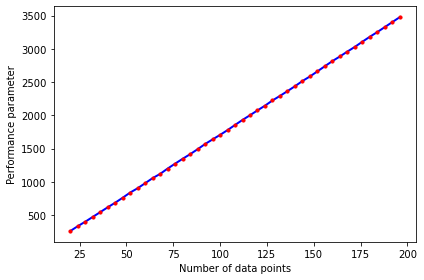

In [52]:
# Set up performance parameters set
list_DATA_POINTS = np.array([])
list_mse = np.array([])
list_lml = np.array([])

for NUM_OF_DATA_POINTS in range(8,200,4):
    X,Y,X_num,x_normal = data_setup(NUM_OF_DATA_POINTS,y_normal)
    gp.fit(X,Y)
    y_mean, sigma = gp.predict(x_normal,  return_std=True)
    # Collect mse and lml infomation
    mse = mean_squared_error(y_normal,y_mean)
    lml = gp.log_marginal_likelihood(gp.kernel_.theta)

    if mse < MAX_mse_allowed:
        list_DATA_POINTS = np.append(list_DATA_POINTS,X.size/8)
        list_mse = np.append(list_mse,mse)
        list_lml = np.append(list_lml,lml)
    else:
        print('Excessive mse at %s points = %s' %(X.size/8,mse))

# plot relevant graphs
print('\nMean squared error')
plot_performance(list_DATA_POINTS,list_mse)
print('Log marginal likelihood')
plot_performance(list_DATA_POINTS,list_lml)

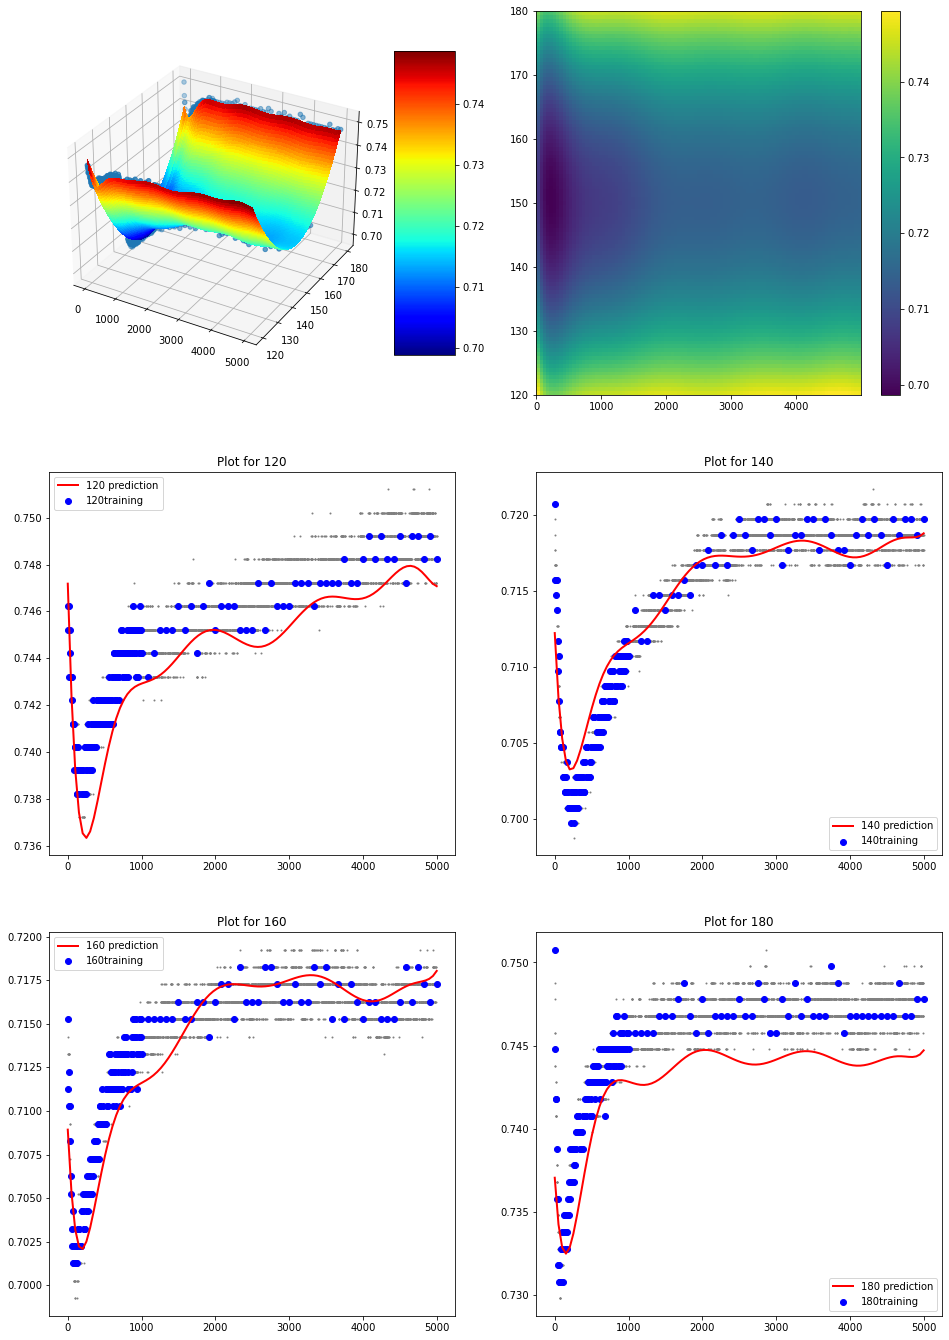

In [53]:
plot(gp,X,temp_list,NUM_OF_PLOT_POINTS,NUM_OF_DATA_POINTS)

In [29]:
# old code for 1d plots comparison
def ucb(X , gp, dim, delta):
	"""
	Calculates the GP-UCB acquisition function values
	Inputs: gp: The Gaussian process, also contains all data
		x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""
	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	mean = np.atleast_2d(mean).T
	var = np.atleast_2d(var).T  
	beta = 2*np.log(np.power(5000,2.1)*np.square(np.pi)/(3*delta))
	return mean - np.sqrt(beta)* np.sqrt(np.diag(var))

# Plot function to show performance of gp prediction
def plot_performance(list_DATA_POINTS,performance_parameter):
    plt.figure()
    plt.plot(list_DATA_POINTS, performance_parameter, c='blue', lw=2, zorder=3)
    plt.scatter(list_DATA_POINTS, performance_parameter, c='red', s=10, zorder=4)
    # plt.xscale('log')
    plt.tick_params(axis='y')
    plt.tick_params(axis='x')
    plt.ylabel('Performance parameter')
    plt.xlabel('Number of data points')
    # plt.ylim(0,0.00001)
    # plt.title('Performance of gp',color ='white')
    plt.tight_layout()
    plt.show()

def plot_UCB (X_,y_normal,X,y_mean, sigma,gp):
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)
    y_ucb = ucb(X_,gp,0.1,5)
    y_ucb = y_ucb.reshape(5000)
    plt.figure()
    plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
    plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
    plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                        alpha=0.5,color='grey',zorder=2, label='95% confidence interval')
    plt.scatter(X_,y_normal,c='lightblue',s=1,zorder=1, label='Experiment data')
    plt.scatter(X_,y_ucb,c='lightgreen',s=1,zorder=5, label='UCB')
    plt.scatter(np.argmin(y_ucb),y_ucb.min(),c='green',s=10,zorder=6,label = 'UCB minimum point')
    plt.tick_params(axis='y')
    plt.tick_params(axis='x')
    plt.ylabel('Lifetime')
    plt.xlabel('Time')
    plt.title("Number of data points: %s\nLog marginal likelihood: %s" % 
                (X.size,gp.log_marginal_likelihood(gp.kernel_.theta)))
    plt.legend()
    plt.tight_layout()
    # plt.savefig('BO_plot.jpg',dpi=600,format='jpg')
    plt.show()

In [60]:

### Initial data initialization
# (either evenly spread OR randomly chosen)
## 1. Have data points evenly spread
X = np.arange(0,4998,5000/(NUM_OF_DATA_POINTS-1)).astype(int)
X = np.append(4999,X)
## 2. Randomly chosed data points
# X = np.random.randint(5000, size=NUM_OF_DATA_POINTS)
##
# Formating data
X = X.reshape(X.size,1)
Y = y_normal[X]
# Set up performance parameters set
list_DATA_POINTS = np.array([])
list_mse = np.array([])
list_lml = np.array([])
# Kernel setting and prediction
kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 10e-4))
gp = GaussianProcessRegressor(kernel=kernel,alpha=10e-8).fit(X, Y)
y_mean, sigma = gp.predict(X_[:, np.newaxis],  return_std=True)
plot(X_,y_normal,X,y_mean, sigma,gp)
# Collect mse and lml infomation
mse = mean_squared_error(y_normal,y_mean)
lml = gp.log_marginal_likelihood(gp.kernel_.theta)
list_DATA_POINTS = np.append(list_DATA_POINTS,X.size)
list_mse = np.append(list_mse,mse)
list_lml = np.append(list_lml,lml)

### loop to find next data point automatically by the desired way
for i in range(NUM_OF_EXTRA_DATA):
    ### followings are a few different ways to choose next point 
    ###(uncomment the one you want and comment the others to work)
    ## 1. by picking lowest UCB value
    # y_ucb = ucb(X_,gp,0.1,5)
    # y_ucb = y_ucb.reshape(5000)
    # X_next =np.argmin(y_ucb)
    # kernel_alpha = 5e-7

    ## 2. by the biggest distance between prediction adn experiment data
    y_mean = y_mean.reshape(5000)
    y_distance = np.absolute(y_mean-y_normal)
    y_distance = y_distance.reshape(5000)
    X_next = np.argmax(y_distance)
    kernel_alpha = 1e-5

    ## 3. by picking the minimum prediction value
    ## (if the value has already used in model training, go to next one til not repeated)
    # y_mean = y_mean.reshape(5000)
    # X_next = np.argmin(y_mean)
    # while X_next in X:
    #     X_next +=1
    # kernel_alpha = 1e-8

    ##
    X = np.append(X,X_next)
    X.sort()
    X=X.reshape(X.size,1)
    Y = y_normal[X]

    # Kernel setting and prediction
    kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 10e-4))
    gp = GaussianProcessRegressor(kernel=kernel,alpha=kernel_alpha).fit(X, Y)
    y_mean, sigma = gp.predict(X_[:, np.newaxis],  return_std=True)
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)

    # Collect mse and lml infomation
    mse = mean_squared_error(y_normal,y_mean)
    lml = gp.log_marginal_likelihood(gp.kernel_.theta)
    # Prevent not fitting model from creating outliers
    if mse < MAX_mse_allowed:
        list_DATA_POINTS = np.append(list_DATA_POINTS,X.size)
        list_mse = np.append(list_mse,mse)
        list_lml = np.append(list_lml,lml)
    else:
        print('Excessive mse at %s points = %s' %(X.size,mse))
    # plot prediction graph in every 10 iterations
    if (X.size)%999 == 0:
        plt.figure()
        plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
        plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
        plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                            alpha=0.5,color='grey',zorder=2, label='95% confidence interval')
        plt.plot(X_,y_normal,c='lightblue',lw=1,zorder=1, label='Experiment data')
        plt.scatter(X_next,y_mean[X_next],c='green', s=10,zorder=6,label = 'Next point')
        plt.tick_params(axis='y')
        plt.tick_params(axis='x')
        plt.ylabel('Lifetime')
        plt.xlabel('Time')
        plt.title("Number of data points: %s\nLog marginal likelihood: %s" % 
                    (X.size,gp.log_marginal_likelihood(gp.kernel_.theta)))
        plt.legend()
        plt.tight_layout()
        # plt.savefig('BO_plot.jpg',dpi=600,format='jpg')
        plt.show()

# plot relevant graphs
print('\nMean squared error')
plot_performance(list_DATA_POINTS,list_mse)
print('Log marginal likelihood')
plot_performance(list_DATA_POINTS,list_lml)